<a href="https://colab.research.google.com/github/yashpatel5400/crypto-prediction/blob/main/stats_601_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [315]:
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.tree import DecisionTreeRegressor
import urllib.request

url = "https://media.githubusercontent.com/media/yashpatel5400/crypto-prediction/main/log_pr.csv"
urllib.request.urlretrieve(url, "log_pr.csv")

url = "https://media.githubusercontent.com/media/yashpatel5400/crypto-prediction/main/volu.csv"
urllib.request.urlretrieve(url, "volu.csv")

('volu.csv', <http.client.HTTPMessage at 0x7ff366fd7050>)

In [307]:
log_pr = pd.read_csv("log_pr.csv", index_col= 0)
volu = pd.read_csv("volu.csv", index_col= 0)

print(len(log_pr))

log_pr.index = pd.to_datetime(log_pr.index)
volu.index = pd.to_datetime(volu.index)

in_sample_size = 50000
out_sample_size = 25000
set_size = in_sample_size + out_sample_size

start_index = 0
log_pr_kfolds = []
volu_kfolds = []
while start_index + set_size < len(log_pr):
  end_index = start_index + set_size
  log_prfold = log_pr.iloc[start_index:end_index, :] 
  volufold = volu.iloc[start_index:end_index, :] 

  log_pr_kfolds.append((log_prfold.iloc[:-out_sample_size, :], log_prfold.iloc[-out_sample_size:, :])) #(train, test)
  volu_kfolds.append((volufold.iloc[:-out_sample_size, :], volufold.iloc[-out_sample_size:, :]))
  start_index += out_sample_size

print(len(log_pr_kfolds))

train_size = 0
out_sample_size = len(log_pr)-1
log_pr_anchoredfolds = []
volu_anchoredfolds = []
while train_size +  out_sample_size < len(log_pr):
  log_pr_anchoredfolds.append((log_pr.iloc[0:train_size, :] , log_pr.iloc[train_size:train_size+out_sample_size, :])) #(train, test)
  volu_anchoredfolds.append((volu.iloc[0:train_size, :] , volu.iloc[train_size:train_size+out_sample_size, :])) #(train, test)
  train_size += out_sample_size

print(len(log_pr_anchoredfolds))

264960
8
1


# Construct features and dataset

In [308]:
def construct_features(log_pr_df, vol_df):
    df = log_pr_df.copy()
    # ema21 = log_pr_df.ewm(span=21, min_periods=5, adjust=False).mean().fillna(1)
    # ema35 = log_pr_df.ewm(span=35, min_periods=10, adjust=False).mean().fillna(1)
    ema80 = log_pr_df.ewm(span=80, min_periods=20, adjust=False).mean().fillna(1)
    # ema250 = log_pr_df.ewm(span=250, min_periods=30, adjust=False).mean().fillna(1)

    # ema12 = log_pr_df.ewm(span=12, min_periods=12, adjust=False).mean().fillna(1)
    # ema26 = log_pr_df.ewm(span=26, min_periods=26, adjust=False).mean().fillna(1)
    # macd = ema12 - ema26
    # macd_s = macd.ewm(span=9, min_periods=9, adjust=False).mean().fillna(1)
    # macd_h = macd - macd_s
    
    # ## simple moving averaga and rollinger bands
    # sma = log_pr_df.rolling(window = 60).mean()
    # sma = sma.fillna(sma.iloc[60])
    # rstd = log_pr_df.rolling(window = 60).std()
    # rstd = rstd.fillna(rstd.iloc[60])
    # upper_bollinger = sma - 2*rstd
    # lower_bollinger = sma +2*rstd

    # # relative strength index
    # delta = log_pr_df.diff(periods = 1).fillna(0)
    # delta_neg = delta.clip(upper=0).abs()
    # delta_pos = delta.clip(lower=0)
    # down = delta_neg.ewm(span=60, adjust=False).mean().fillna(1)
    # up = delta_pos.ewm(span=60, adjust=False).mean().fillna(1)
    # rs = (up/down).replace([np.inf, np.nan],1)
    # rsi = 100- 100/(1+rs)

    # #standardized volume
    vol_train_mean = volu.mean()
    vol_train_sd = volu.std()
    vol_standardized = (vol_df - vol_train_mean)/vol_train_sd
    # df = pd.concat([ema80, vol_standardized, lower_bollinger, upper_bollinger, rsi, macd], axis=1)
    df = pd.concat([ema80, vol_standardized], axis=1)
    return df

In [309]:
def construct_dataset(window_size, features, log_prices):
    """
    window: look-back window size for constructing X (in minutes)
    """
    window_dt = datetime.timedelta(minutes=window_size)
    predict_dt = datetime.timedelta(minutes=30)

    window_X = []
    window_y = []

    for t in features.index[window_size:-window_size:10]: # compute the predictions every 10 minutes
      window_X.append(features.loc[(t - window_dt):t])
      window_y.append(log_prices.loc[t + predict_dt] - log_prices.loc[t])
        
    return np.array(window_X), np.array(window_y)

In [310]:
def split_dataset_by_asset(dataset_train):
  NUM_ASSETS = 10
  return [dataset_train[..., asset::NUM_ASSETS] for asset in range(NUM_ASSETS)]

In [311]:
def construct_local_features(asset_window):
  """
  construct features for *single windowed asset*

  NOTE: for adding new features, see asset_window[...,0] for np.std
  Here, 0 is the feature that is being pulled out (corresponds to the index from global_feature construction)
  from which you can do whatever transforms you want
  """
  local_features = [asset_window.reshape(asset_window.shape[0], -1)] # flattens *per* training example
  local_features.append(np.std(asset_window[...,0], axis=-1, keepdims=True))
  return np.hstack(local_features)

In [312]:
def train_models_split(dataset_train_by_asset, y_train, train_idxs, model_types):
  NUM_ASSETS = 10
  return [(model_types[asset]().fit(construct_local_features(dataset_train_by_asset[asset]), 
                           y_train[:, asset]), asset) 
          for asset in range(NUM_ASSETS) if asset in train_idxs]

In [317]:
def get_r_hat_clean(A,B):
  window_size = 61

  input_features = (construct_features(A, B)).iloc[-window_size:] # only retain tail window
  predictions = -(input_features.iloc[-1, :10] - input_features.iloc[-30,:10]).values # init baseline
  input_features = input_features.values
  split_features_by_asset = split_dataset_by_asset(input_features)
  for model, asset_idx in split_models:
    # if model is not None:
      # expand_dims is used to align dimensions from "batching" used in training
    predictions[asset_idx] = model.predict(construct_local_features(np.expand_dims(split_features_by_asset[asset_idx], axis=0)))
  return predictions

In [ ]:
tracker = []
for k in range(len(log_pr_kfolds)):
  print(f"Performing {k} fold...")
  log_pr_train, log_pr_test = log_pr_kfolds[k]
  volu_train, volu_test  = volu_kfolds[k]
  features = construct_features(log_pr_train, volu_train)
  print

  print(log_pr_train.shape)
  print(log_pr_test.shape)

  window_size = 60 # in minutes
  X_train, y_train = construct_dataset(window_size, features, log_pr_train)
  X_train_by_asset = split_dataset_by_asset(X_train)
  # 0, 3, 5 this gave 0.022
  print(X_train.shape)
  split_models = train_models_split(X_train_by_asset, y_train, [0, 1, 3, 5], [RidgeCV] * 10)

  def get_model_corr(test_log_pr, test_volu):
    w = 60
    t0 = time.time()
    dt = datetime.timedelta(days=1)
    r_hat = pd.DataFrame(index=test_log_pr.index[w::10], columns=np.arange(10), dtype=np.float64)
    print(r_hat.shape)
    for t in test_log_pr.index[w::10]: # compute the predictions every 10 minutes
        r_hat.loc[t, :] = get_r_hat_clean(test_log_pr.loc[(t - dt):t], test_volu.loc[(t - dt):t])
    t_used = time.time() - t0
    
    r_fwd = (test_log_pr.shift(-30) - test_log_pr).iloc[w::10].rename(columns={f"input_df_{i}": i for i in range(10)})
    r_fwd.corrwith(r_hat)
    
    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final "ignore_rows" rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

  t0 = time.time()
  ans = get_model_corr(log_pr_test, volu_test)
  tracker.append(ans)
  t_used = time.time() - t0

Performing 0 fold...
(50000, 10)
(25000, 10)
(4988, 61, 20)
(2494, 10)
Performing 1 fold...
(50000, 10)
(25000, 10)
(4988, 61, 20)
(2494, 10)


In [306]:
print(tracker)
print(np.average(tracker))
print(np.median(tracker))
print(np.max(tracker))
print(np.min(tracker))
print(np.average(np.abs(tracker)))

[0.0004252357837022313, -0.006044738055682299, 0.017096747251871502, 0.0007850543295373177, 0.0038997097649715352, -0.0064928978562632045, -0.00016686259522599546, -0.01057525721489505]
-0.0001341260739979957
0.0001291865942381179
0.017096747251871502
-0.01057525721489505
0.005685812856518642


# Clustering Analysis

In [283]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
std_pr = log_pr.std(axis=0).values.reshape(-1, 1)
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10]
mean_pr = r_fwd.mean(axis=0).values.reshape(-1, 1)
std_fwd_pr =r_fwd.std(axis=0).values.reshape(-1, 1)

volu_log = np.log(volu + 1)
v_fwd = (volu_log.shift(-30) - volu_log).iloc[30::10]
std_vol = volu_log.std(axis=0).values.reshape(-1, 1)
mean_vol = v_fwd.mean(axis=0).values.reshape(-1, 1)
std_fwd_vol = v_fwd.std(axis=0).values.reshape(-1, 1)

features = np.concatenate((mean_pr, std_pr, std_vol, mean_vol, std_fwd_vol, std_fwd_pr), axis = 1)
print(features.shape)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

(10, 6)


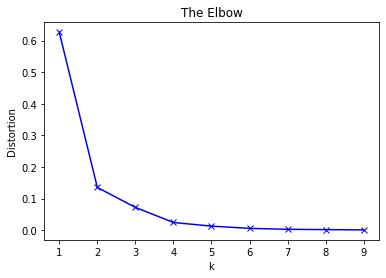

In [284]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow')
plt.show()

In [285]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(features)
print(kmeanModel.labels_)

[0 0 1 2 2 0 2 2 2 2]


In [286]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(features)
clustering.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

# Data Visualization

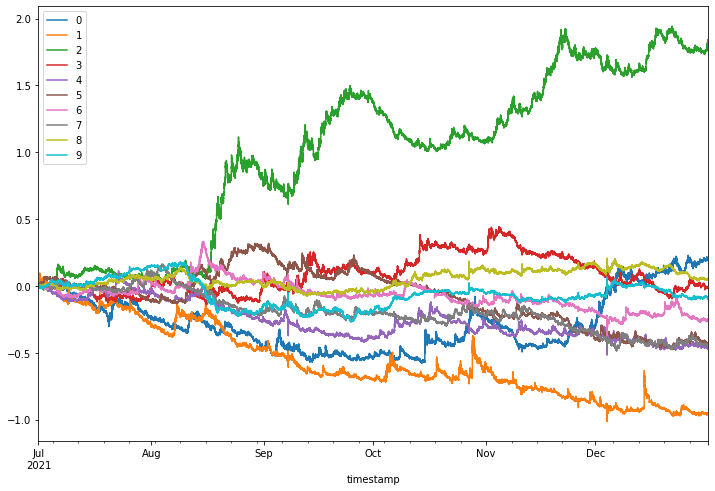

In [287]:
log_pr.plot(figsize=(12, 8))

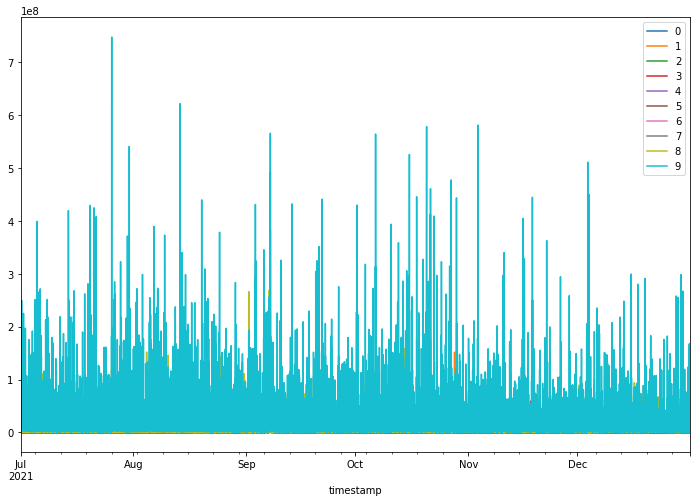

In [288]:
volu.plot(figsize=(12, 8))

# Appendix

## Models

##LSTMs

In [289]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [290]:
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
y_train_tensors = Variable(torch.Tensor(y_train).to(device))

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)

Training Shape torch.Size([4988, 61, 20]) torch.Size([4988, 10])


In [291]:
class LSTM1(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.output_size = output_size #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(32, output_size) #fully connected last layer
    
    def forward(self,x):
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc1(hn)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc(out) #Final Output
        return out

In [292]:
num_epochs = 100 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = X_train.shape[-1] #number of features
print(input_size)
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 10 #number of output classes

lstm1 = LSTM1(output_size, input_size, hidden_size, num_layers) 
lstm1 = lstm1.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

print(X_train_tensors.shape)

20
torch.Size([4988, 61, 20])


In [293]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) 
  optimizer.zero_grad() 
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() 
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 2 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.00703


KeyboardInterrupt: ignored

In [ ]:
lstm1 = lstm1.to(torch.device("cpu"))
torch.save(lstm1.state_dict(), "/content/lstm_model.pth")

In [ ]:
print( np.expand_dims(log_pr.iloc[-31:, :].to_numpy(), 0).shape)

In [ ]:
lstm1.load_state_dict(torch.load("/content/lstm_model.pth"))
lstm1.eval()
lstm1 = lstm1.to(torch.device("cpu"))

##GBoost

In [ ]:
model_0 = lgb.LGBMRegressor()
print(X_train.shape)
X_train_asset0 = np.array(X_train[:, :, 0])
X_train_asset2 = np.array(X_train[:, :, 2])
X_train_asset3 = np.array(X_train[:, :, 3])
X_train_asset1 = np.array(X_train[:, :, 1])

y_train_asset0 = np.array(y_train[:, 0])
y_train_asset2 = np.array(y_train[:, 2])
y_train_asset3 = np.array(y_train[:, 3])
y_train_asset1 = np.array(y_train[:, 1])

model_2 = lgb.LGBMRegressor()
model_3 = lgb.LGBMRegressor()
model_1 = lgb.LGBMRegressor()


model_0.fit(X_train_asset0, y_train_asset0)
model_2.fit(X_train_asset2, y_train_asset2)
model_3.fit(X_train_asset3, y_train_asset3)
model_1.fit(X_train_asset1, y_train_asset1)

model_0.booster_.save_model('model_0.txt')
model_2.booster_.save_model('model_2.txt')
model_3.booster_.save_model('model_3.txt')
model_1.booster_.save_model('model_1.txt')

In [ ]:
model_0 = lgb.Booster(model_file='model_0.txt')
model_2 = lgb.Booster(model_file='model_2.txt')
model_3 = lgb.Booster(model_file='model_3.txt')
model_1 = lgb.Booster(model_file='model_1.txt')

##GBoost + Ridge

In [ ]:
model_2 = lgb.LGBMRegressor()
model_01 = Ridge()
model_35 = Ridge()

#X_train_asset2 = np.array(X_train[:, :, 2])
X_train_asset2 = np.concatenate([X_train[:, :, 2], X_train[:, :, 12], np.array([np.std(X_train[:, :, 2], axis = 1)]).T], axis =1)
X_train_asset01 = np.concatenate((X_train[:, :, 0], X_train[:, :, 1]), axis=1)

X_train_asset35 = np.concatenate((X_train[:, :, 3], X_train[:, :, 5]), axis=1)

y_train_asset2 = np.array(y_train[:, 2])
y_train_asset01 = np.concatenate((y_train[:, 0:1], y_train[:, 1:2]), axis=1)
y_train_asset35 = np.concatenate((y_train[:, 3:4], y_train[:, 5:6]), axis=1)

model_2.fit(X_train_asset2, y_train_asset2)
model_01.fit(X_train_asset01, y_train_asset01)
model_35.fit(X_train_asset35, y_train_asset35)



##Ridge+Huber





In [ ]:
X_train

In [ ]:
def train_models(X_train, y_train):
  X_train_asset0 = np.concatenate([X_train[:, :, 0], X_train[:, :, 10], np.array([np.std(X_train[:, :, 0], axis = 1)]).T], axis =1)
  X_train_asset1 = np.concatenate([X_train[:, :, 1], X_train[:, :, 11], np.array([np.std(X_train[:, :, 1], axis = 1)]).T], axis =1)
  X_train_asset2 = np.concatenate([X_train[:, :, 2], X_train[:, :, 12], np.array([np.std(X_train[:, :, 2], axis = 1)]).T], axis =1)
  X_train_asset3 = np.concatenate([X_train[:, :, 3], X_train[:, :, 13], np.array([np.std(X_train[:, :, 3], axis = 1)]).T], axis =1)
  X_train_asset4 = np.concatenate([X_train[:, :, 4], X_train[:, :, 14], np.array([np.std(X_train[:, :, 4], axis = 1)]).T], axis =1)
  X_train_asset5 = np.concatenate([X_train[:, :, 5], X_train[:, :, 15], np.array([np.std(X_train[:, :, 5], axis = 1)]).T], axis =1)
  X_train_asset6 = np.array(X_train[:, :, 6])
  X_train_asset7 = np.array(X_train[:, :, 7])
  X_train_asset8 = np.array(X_train[:, :, 8])
  X_train_asset9 = np.array(X_train[:, :, 9])

  y_train_asset0 = np.array(y_train[:, 0])
  y_train_asset1 = np.array(y_train[:, 1])
  y_train_asset2 = np.array(y_train[:, 2])
  y_train_asset3 = np.array(y_train[:, 3])
  y_train_asset4 = np.array(y_train[:, 4])
  y_train_asset5 = np.array(y_train[:, 5])
  y_train_asset6 = np.array(y_train[:, 6])
  y_train_asset7 = np.array(y_train[:, 7])
  y_train_asset8 = np.array(y_train[:, 8])
  y_train_asset9 = np.array(y_train[:, 9])

  model_0 = Ridge()
  model_1 = Ridge()
  model_2 = Ridge()
  model_3 = Ridge()
  model_4 = Ridge()
  model_5 = Ridge()


  print(X_train_asset0.shape)
  model_0.fit(X_train_asset0, y_train_asset0)
  model_1.fit(X_train_asset1, y_train_asset1)
  model_2.fit(X_train_asset2, y_train_asset2)
  model_3.fit(X_train_asset3, y_train_asset3)
  #model_4.fit(X_train_asset4, y_train_asset4)
  model_5.fit(X_train_asset5, y_train_asset5)
  #model_6.fit(X_train_asset6, y_train_asset6)
  ##model_7.fit(X_train_asset7, y_train_asset7)
  #model_8.fit(X_train_asset8, y_train_asset8)
  #model_9.fit(X_train_asset9, y_train_asset9)
  return model_0, model_1, model_2, model_3, model_5


## Evaluation

In [ ]:
# Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns
#predict the log price, and then do correlation
def get_r_hat_baseline(A, B):
    return -(A.iloc[-1] - A.iloc[-30]).values 

In [ ]:
def get_r_hat_lstm(A, B):
  input = np.expand_dims(construct_features(A, B).values, axis=0)
  input = Variable(torch.Tensor(input))
  pred = lstm1(input).detach().cpu().numpy()
  return pred.squeeze()

In [ ]:
def get_r_hat_complex(A, B):
  w = 31
  input = construct_features(A, B)
  tmp = -(input.iloc[-1] - input.iloc[-30]).values
  asset_0_pred = model_0.predict(np.expand_dims(input.iloc[-w:, 0].values, axis=0)) 
  #asset_2_pred = model_2.predict(np.expand_dims(input.iloc[-w:, 2].values, axis=0))
  asset_2_pred = model_2.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 2].values, input.iloc[-w:, 12].values, [np.std(input.iloc[-w:, 2].values)]]), axis=0))
  asset_3_pred = model_3.predict(np.expand_dims(input.iloc[-w:, 3].values, axis=0))
  asset_1_pred = model_1.predict(np.expand_dims(input.iloc[-w:, 1].values, axis=0))
  tmp[0] = asset_0_pred[0]
  tmp[2] = asset_2_pred[0]
  tmp[3] = asset_3_pred[0]
  tmp[1] = asset_1_pred[0]

  return tmp

In [ ]:
def get_r_hat_more_features(A,B):
  w = 61
  input = construct_features(A, B)
  tmp = -(input.iloc[-1, :10] - input.iloc[-30,:10]).values
  asset_0_pred = model_0.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 0].values, input.iloc[-w:, 10].values, [np.std(input.iloc[-w:, 0].values)]]), axis=0))
  asset_2_pred = model_2.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 2].values, input.iloc[-w:, 12].values, [np.std(input.iloc[-w:, 2].values)]]), axis=0))
  asset_3_pred = model_3.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 3].values, input.iloc[-w:, 13].values, [np.std(input.iloc[-w:, 3].values)]]), axis=0))
  asset_1_pred = model_1.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 1].values, input.iloc[-w:, 11].values, [np.std(input.iloc[-w:, 1].values)]]), axis=0))
  #asset_4_pred = model_4.predict(np.expand_dims(np.concatenate([input.iloc[-61:, 4].values, input.iloc[-61:, 14].values, [np.std(input.iloc[-61:, 4].values)]]), axis=0)) 
  asset_5_pred = model_5.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 5].values, input.iloc[-w:, 15].values, [np.std(input.iloc[-w:, 5].values)]]), axis=0))
  #asset_5_pred = model_5.predict(np.expand_dims(input.iloc[-61:, 5].values, axis=0))
  #asset_6_pred = model_6.predict(np.expand_dims(input.iloc[-61:, 6].values, axis=0))
  #asset_7_pred = model_7.predict(np.expand_dims(input.iloc[-61:, 7].values, axis=0))
  #asset_8_pred = model_8.predict(np.expand_dims(input.iloc[-61:, 8].values, axis=0))
  #asset_9_pred = model_9.predict(np.expand_dims(input.iloc[-61:, 9].values, axis=0))
  tmp[0] = asset_0_pred[0]
  tmp[2] = asset_2_pred[0]
  tmp[3] = asset_3_pred[0]
  tmp[1] = asset_1_pred[0]
  #tmp[4] = asset_4_pred[0]
  tmp[5] = asset_5_pred[0]
  #tmp[6] = asset_6_pred[0]
  #tmp[7] = asset_7_pred[0]
  #tmp[8] = asset_8_pred[0]
  #tmp[9] = asset_9_pred[0]


  return tmp

In [ ]:
def get_r_hat_simple(A, B):
  input = construct_features(A, B)
  return -(input.iloc[-1] - input.iloc[-30]).values 

In [ ]:
def get_r_hat_ridge_boost(A, B):
  input = construct_features(A, B)
  tmp = -(input.iloc[-1] - input.iloc[-30]).values
  #asset_2_pred = model_2.predict(np.expand_dims(input.iloc[-61:, 2].values, axis=0))
  asset_2_pred = model_2.predict(np.expand_dims(np.concatenate([input.iloc[-61:, 2].values, input.iloc[-61:, 12].values, [np.std(input.iloc[-61:, 2].values)]]), axis=0))
  input_01 = np.concatenate((input.iloc[-61:, 0:1].values, input.iloc[-61:, 1:2].values), axis=1).reshape(1, -1)
  asset_01_pred = np.squeeze(model_01.predict(input_01))

  input_35 = np.concatenate((input.iloc[-61:, 3:4].values, input.iloc[-61:, 5:6].values), axis=1).reshape(1, -1)
  asset_35_pred = np.squeeze(model_35.predict(input_35))

  tmp[2] = asset_2_pred[0]
  tmp[0] = asset_01_pred[0]
  tmp[1] = asset_01_pred[1]
  tmp[3] = asset_35_pred[0]
  tmp[5] = asset_35_pred[1]


  return tmp


In [ ]:
# An example of get_r_hat

ACTIVE_R_HAT = "more_features"

r_hat_implementations = {
    "baseline": get_r_hat_baseline, 
    "lstm": get_r_hat_lstm,
    "simple":get_r_hat_simple,
    "complex": get_r_hat_complex, 
    "ridge_boost": get_r_hat_ridge_boost,
    "more_features": get_r_hat_more_features
}

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    return r_hat_implementations[ACTIVE_R_HAT](A, B)

In [ ]:
def get_model_corr(test_log_pr, test_volu):
    t0 = time.time()
    dt = datetime.timedelta(days=1)
    r_hat = pd.DataFrame(index=test_log_pr.index[1440::10], columns=np.arange(10), dtype=np.float64)
    for t in test_log_pr.index[1440::10]: # compute the predictions every 10 minutes
        r_hat.loc[t, :] = get_r_hat(test_log_pr.loc[(t - dt):t], test_volu.loc[(t - dt):t])
    t_used = time.time() - t0
    
    r_fwd = (test_log_pr.shift(-30) - test_log_pr).iloc[1440::10].rename(columns={f"input_df_{i}": i for i in range(10)})
    r_fwd.corrwith(r_hat)
    
    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final "ignore_rows" rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

In [ ]:
tracker = []
for k in range(len(log_pr_kfolds)):
  print(k)
  log_pr_train, log_pr_test = log_pr_kfolds[k]
  volu_train, volu_test  = log_pr_kfolds[k]

  features = construct_features(log_pr_train, volu_train)
  window_size = 60 # in minutes
  X_train, y_train = construct_dataset(window_size, features, log_pr_train)

  print(X_train.shape)

  model_0, model_1, model_2, model_3, model_5 = train_models(X_train, y_train)

  def get_r_hat(A,B):
    w = 61
    input = construct_features(A, B)
    tmp = -(input.iloc[-1, :10] - input.iloc[-30,:10]).values
    asset_0_pred = model_0.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 0].values, input.iloc[-w:, 10].values, [np.std(input.iloc[-w:, 0].values)]]), axis=0))
    asset_2_pred = model_2.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 2].values, input.iloc[-w:, 12].values, [np.std(input.iloc[-w:, 2].values)]]), axis=0))
    asset_3_pred = model_3.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 3].values, input.iloc[-w:, 13].values, [np.std(input.iloc[-w:, 3].values)]]), axis=0))
    asset_1_pred = model_1.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 1].values, input.iloc[-w:, 11].values, [np.std(input.iloc[-w:, 1].values)]]), axis=0))
    asset_5_pred = model_5.predict(np.expand_dims(np.concatenate([input.iloc[-w:, 5].values, input.iloc[-w:, 15].values, [np.std(input.iloc[-w:, 5].values)]]), axis=0))
    tmp[0] = asset_0_pred[0]
    tmp[2] = asset_2_pred[0]
    tmp[3] = asset_3_pred[0]
    tmp[1] = asset_1_pred[0]
    tmp[5] = asset_5_pred[0]

    return tmp

  def get_model_corr(test_log_pr, test_volu):
    w = 60
    t0 = time.time()
    dt = datetime.timedelta(days=1)
    r_hat = pd.DataFrame(index=test_log_pr.index[w::10], columns=np.arange(10), dtype=np.float64)
    print(r_hat.shape)
    for t in test_log_pr.index[w::10]: # compute the predictions every 10 minutes
        r_hat.loc[t, :] = get_r_hat_clean(test_log_pr.loc[(t - dt):t], test_volu.loc[(t - dt):t])
    t_used = time.time() - t0
    
    r_fwd = (test_log_pr.shift(-30) - test_log_pr).iloc[w::10].rename(columns={f"input_df_{i}": i for i in range(10)})
    r_fwd.corrwith(r_hat)
    
    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final "ignore_rows" rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

  t0 = time.time()
  ans = get_model_corr(log_pr_test, volu_test)
  tracker.append(ans)
  t_used = time.time() - t0


In [ ]:
print(tracker)
print(np.average(tracker))
print(np.median(tracker))
print(np.max(tracker))
print(np.min(tracker))
print(np.average(np.abs(tracker)))